In [8]:
! pip install opencv-python
! pip install pytesseract
! pip install numpy
! pip install matplotlib
! pip install ipynb

import cv2
print(f'OpenCV Version: {cv2.__version__}')
import pytesseract
print(f'Pytesseract Version: {pytesseract.__version__}')
import numpy as np
print(f'Numpy Version: {np.__version__}')
import matplotlib
print(f'Matplotlib Version: {matplotlib.__version__}')

OpenCV Version: 4.5.5
Pytesseract Version: 0.3.9
Numpy Version: 1.20.3
Matplotlib Version: 3.4.3


player cards:  ['4', 'J']
dealer cards:  ['K']
Player hand value:  14
Dealer hand value:  10
Simple:  Hit
0.3868083694955169
0.22892834325524963
Recursive:  Hit


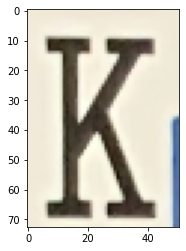

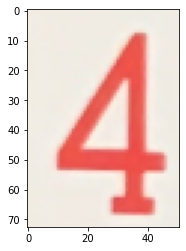

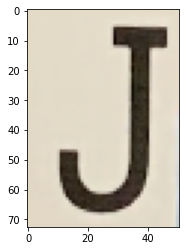

<Figure size 432x288 with 0 Axes>

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pytesseract
import import_ipynb
from ipynb.fs.full.simple_blackjack import simple
from ipynb.fs.full.recursive_blackjack import recursive_blackjack

input_img = cv2.imread('Card_Imgs/DetFirstHand.jpg', 1)

def crop_num(img):
    # convert the image to HSV color space
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # find Otsu threshold on value channel (white can be any Hue/Satuation)
    ret, thresh_V = cv2.threshold(img_hsv[:,:,2], 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # some morphology operation to clear unwanted spots
    kernel = np.ones((5, 5), np.uint8)
    thresh = thresh_V
    img_dilated = cv2.dilate(thresh, kernel, iterations = 1)

    # find contours on the result above
    contours, hierarchy = cv2.findContours(img_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    results = []
    contours = list(contours)
    contours.sort(key = lambda x: x[0,0,1]) #Sort by contours on y-axis
    for c in contours:
        if cv2.contourArea(c) > 500000: #Loop through contours with an area larger than 500000
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.015 * peri, True)
        
            if len(approx) == 4:
                screenCnt = approx
            
        
            pts = screenCnt.reshape(4, 2)
            rect = np.zeros((4, 2), dtype = "float32")
        
            s = pts.sum(axis = 1)
            rect[0] = pts[np.argmin(s)]
            rect[2] = pts[np.argmax(s)]
        
            diff = np.diff(pts, axis = 1)
            rect[1] = pts[np.argmin(diff)]
            rect[3] = pts[np.argmax(diff)]
            
            #Define top-left, top-right, bottom-right, bottom-left corner
            dst = np.array([[0, 0],[384, 0],[384, 600],[0, 600]], dtype = "float32")
            M = cv2.getPerspectiveTransform(rect, dst)
            warp = cv2.warpPerspective(img, M, (384, 600))
            
            warp = warp[15:88, 4:55] #Crop card to number
            results.append(warp)
            
    return results

def read_images(imgs):
    config = ('-c tessedit_char_whitelist=0123456789AJQK -l eng --oem 1 --psm 8')
    results = []
    for i in imgs:
        
        plt.imshow(cv2.cvtColor(i, cv2.COLOR_RGB2BGR))   # Ploting the image using matplotlib
        plt.figure()
        gray = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        # Blur and perform text extraction
        thresh = 255 - cv2.GaussianBlur(thresh, (5,5), 0)
        text = pytesseract.image_to_string(thresh, config=config)
        results.append(text.strip("\n\x0c"))
    return results

def calc_hand_value(cards):
    value_lookup = {'A': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, '%': 3, 'i': 10}
    
    value = 0
    for c in cards:
        #value += value_lookup[c]
        value += value_lookup.get(c, 10)
    
    return value

cropped = crop_num(input_img)
results = read_images(cropped)
#dealer = [results[0], results[1]]
#player = [results[2], results[3]]
dealer = [results[0]]
results.pop(0)
player = results
print("player cards: ", player)
print("dealer cards: ", dealer)
print("Player hand value: ", calc_hand_value(player))
print("Dealer hand value: ", calc_hand_value(dealer))
example_deck = {1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 4, 8: 4, 9: 4, 10: 16}
print('Simple: ', simple(calc_hand_value(player), calc_hand_value(dealer), example_deck))
print('Recursive: ', recursive_blackjack(calc_hand_value(player), calc_hand_value(dealer), example_deck))